# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
!pip install tqdm
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


trainset = torchvision.datasets.MNIST('./', download=True, 
                                      train=True, transform=transform)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST('./', download=True, 
                                     train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

For this problem, the following two transformations are useful for better training convergence:

`torchvision.transforms.ToTensor()`: Convert a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
to tensor (torch.FloatTensor of shape (C x H x W) in the range 
[0.0, 1.0]).

Some activation functions cannot tolerate big values. They will easily saturated and this ruins the training.

`torchvision.transforms.Normalize()`: It will normalize the image in the range [-1,1]. For example, 
the minimum value 0 will be converted to (0-0.5)/0.5=-1, 
the maximum value of 1 will be converted to (1-0.5)/0.5=1. 
You perform it with the hope that the distribution becomes 
nearly standard normal distribution with mean of 0 and 
a variance and standard deviation of 1.

Normalization helps to have a more stable training and better convergence.


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


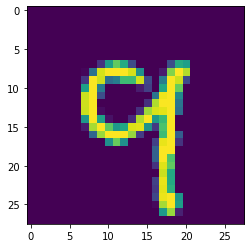

5


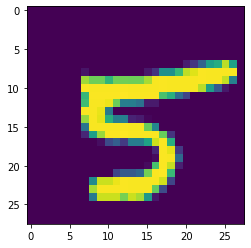

3


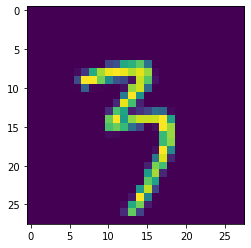

0


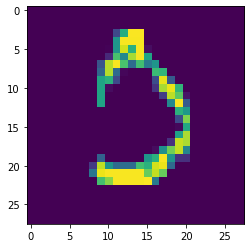

5


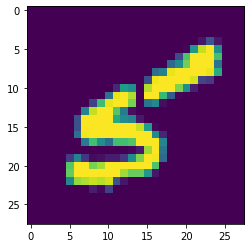

In [7]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

model.to(my_device)

Device: cpu


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
def train_loop(trainloader, model, criterion, optimizer):
    tot_train_loss = 0
    for images, labels in trainloader:
        
        images = images.to(my_device)
        labels = labels.to(my_device)
        
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss = tot_train_loss / len(trainloader.sampler)
    
    return train_loss

def test_loop(testloader, model, criterion):
    tot_test_loss = 0
    test_correct = 0  # Number of correct predictions on the test set

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images, labels in testloader:
            
            images = images.to(my_device)
            labels = labels.to(my_device)
            
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += equals.sum().item()

    test_loss = tot_test_loss / len(testloader.sampler)
    test_acc = test_correct / len(testloader.sampler)
    
    return test_loss, test_acc

In [11]:
epochs = 10

train_losses, test_losses = [], []
    
for e in range(epochs):
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    
    test_loss,test_acc = test_loop(testloader, model, criterion)

    # Keep track of losses at the completion of epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_loss),
          "Test Loss: {:.3f}.. ".format(test_loss),
          "Test Accuracy: {:.3f}".format(test_acc))

Epoch: 1/10..  Training Loss: 0.662..  Test Loss: 0.243..  Test Accuracy: 0.925
Epoch: 2/10..  Training Loss: 0.230..  Test Loss: 0.184..  Test Accuracy: 0.943
Epoch: 3/10..  Training Loss: 0.186..  Test Loss: 0.144..  Test Accuracy: 0.958
Epoch: 4/10..  Training Loss: 0.151..  Test Loss: 0.139..  Test Accuracy: 0.957
Epoch: 5/10..  Training Loss: 0.131..  Test Loss: 0.135..  Test Accuracy: 0.958
Epoch: 6/10..  Training Loss: 0.117..  Test Loss: 0.128..  Test Accuracy: 0.962
Epoch: 7/10..  Training Loss: 0.106..  Test Loss: 0.119..  Test Accuracy: 0.964
Epoch: 8/10..  Training Loss: 0.100..  Test Loss: 0.113..  Test Accuracy: 0.966
Epoch: 9/10..  Training Loss: 0.090..  Test Loss: 0.119..  Test Accuracy: 0.965
Epoch: 10/10..  Training Loss: 0.085..  Test Loss: 0.116..  Test Accuracy: 0.964


Plot the training loss (and validation loss/accuracy, if recorded).

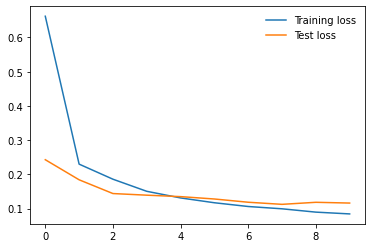

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
test_loss,test_acc = test_loop(testloader, model, criterion)

print("Result on the Final Test Set")
print("Test Loss: {:.3f}.. ".format(test_loss), "Test Accuracy: {:.3f}".format(test_acc))

Result on the Final Test Set
Test Loss: 0.116..  Test Accuracy: 0.964


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
torch.save(model.state_dict(), 'mlp_mnist.pth')